# Explorando datos geográficos

contexto...

## 0 Configuración del entorno

In [1]:
import zipfile
import sys
from pathlib import Path

import requests
import pandas as pd
import geopandas as gpd

In [2]:
ROOT_DIR = Path().resolve().parent

if str(ROOT_DIR) not in sys.path: 
    sys.path.insert(0, str(ROOT_DIR))

In [3]:
from src.config import DATA_DIR, RAW_DIR

In [4]:
GEO_DIR = RAW_DIR / "geo"
GEO_DIR.mkdir(exist_ok=True)

## 1 Polígonos de las colonias en Hermosillo

contexto...

In [5]:
url_colonias = r"https://www.inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/geografia/delimitaciones/794551132180_s.zip"

In [6]:
r_colonias = requests.get(url_colonias)
for k, v in r_colonias.headers.items(): print(k, v)

Cache-Control must-revalidate,max-age=10
Content-Type application/x-zip-compressed
Last-Modified Tue, 17 Dec 2024 21:53:00 GMT
Accept-Ranges bytes
ETag "8ddd46ace50db1:0"
Server Microsoft-IIS/10.0
X-Powered-By ASP.NET
Date Sat, 11 Oct 2025 23:54:29 GMT
Content-Length 71610306
Set-Cookie BIGipServerLB_contenidos2=1164235274.37407.0000; expires=Sun, 12-Oct-2025 00:14:29 GMT; path=/; Httponly; Secure


Nótese que el archivo geojson es bastante pesado (+60 mb), por lo que conviene descargarlo en partes:

In [7]:
path_colonias = GEO_DIR / "colonias"
path_colonias.mkdir(exist_ok=True)

filename_colonias_geojson = Path(url_colonias).name
path_colonias_geojson = path_colonias / filename_colonias_geojson

In [8]:
r_colonias = requests.get(url_colonias, stream=True)

with open(path_colonias_geojson, 'wb') as gf: 
    for chunk in r_colonias.iter_content(chunk_size=10*1024*1024): 
        gf.write(chunk)

In [11]:
for item in path_colonias.iterdir(): print(item.relative_to(ROOT_DIR))

data\raw\geo\colonias\794551132180_s.zip
data\raw\geo\colonias\coloniasine2020.geojson


In [ ]:
with zipfile.ZipFile(path_colonias_geojson, 'r') as zf: 
    zf.extractall(path_colonias)

# path_colonias_geojson.unlink()

Los archivos descomprimidos contienen la siguiente estructura: 

...

Obtenenemos el archivo shapefile: 

In [20]:
for item in path_colonias.rglob("*.shp"):
    print(item.relative_to(ROOT_DIR))

data\raw\geo\colonias\conjunto_de_datos\00as.shp


In [21]:
path_colonias_shp = path_colonias / "conjunto_de_datos" / "00as.shp"
path_colonias_shp.is_file(), path_colonias_shp.exists()

(True, True)

Cargamos el archivo geojson como `GeoDataFrame`: 

In [54]:
gdf_colonias = gpd.read_file(path_colonias_shp)
gdf_colonias.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_ASEN,CP,FECHA_ACT,INSTITUCIO,NOM_ASEN,TIPO,Shape_Leng,Shape_Area,geometry
0,0100100010001,01,001,0001,0001,20263,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,AGUA CLARA,FRACCIONAMIENTO,1107.383585,52767.800484,"POLYGON ((2474021.992 1093915.819, 2474034.109..."
1,0100100010002,01,001,0001,0002,20159,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,ALIANZA FERROCARRILERA,FRACCIONAMIENTO,1938.265565,97261.356447,"POLYGON ((2471105.967 1099065.062, 2471107.515..."
2,0100100010003,01,001,0001,0003,20040,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,ALTAVISTA,COLONIA,2569.108212,368212.263364,"POLYGON ((2468095.184 1097647.988, 2468169.06 ..."
3,0100100010004,01,001,0001,0004,20230,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,LAS AMERICAS,FRACCIONAMIENTO,3548.120214,462805.496892,"POLYGON ((2469185.751 1094893.007, 2469280.792..."
4,0100100010005,01,001,0001,0005,20020,11/2023,SECRETARÍA DE DESARROLLO URBANO DEL MUNICIPIO ...,LAS ARBOLEDAS,FRACCIONAMIENTO,2418.992126,201564.185798,"POLYGON ((2468943.182 1098316.269, 2468946.723..."


In [55]:
gdf_colonias.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75516 entries, 0 to 75515
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CVEGEO      75516 non-null  object  
 1   CVE_ENT     75516 non-null  object  
 2   CVE_MUN     75516 non-null  object  
 3   CVE_LOC     75516 non-null  object  
 4   CVE_ASEN    75516 non-null  object  
 5   CP          75516 non-null  object  
 6   FECHA_ACT   75516 non-null  object  
 7   INSTITUCIO  75516 non-null  object  
 8   NOM_ASEN    75516 non-null  object  
 9   TIPO        75516 non-null  object  
 10  Shape_Leng  75516 non-null  float64 
 11  Shape_Area  75516 non-null  float64 
 12  geometry    75516 non-null  geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 7.5+ MB


In [56]:
gdf_colonias[['CVE_ENT', 'CVE_MUN', 'CVE_LOC']] = gdf_colonias[['CVE_ENT', 'CVE_MUN', 'CVE_LOC']].astype(int)

En el [diccionarió de datos]() se menciona que la clave para colnias de Hermosillo es `CVE_ENT=26` (Sonora) y `CVE_MUN=30`:

In [57]:
gdf_colonias_hmo = gdf_colonias[
    (gdf_colonias['CVE_ENT'] == 26) & 
    (gdf_colonias['CVE_MUN'] == 30)
]
gdf_colonias_hmo.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_ASEN,CP,FECHA_ACT,INSTITUCIO,NOM_ASEN,TIPO,Shape_Leng,Shape_Area,geometry
66032,2603000010001,26,30,1,0001,83290,11/2021,"DIRECCIÓN DE CATASTRO, HERMOSILLO",Y GRIEGA,BARRIO,3242.570807,588003.672042,"POLYGON ((1628676.872 1912677.506, 1628689.302..."
66033,2603000010002,26,30,1,0002,83170,11/2021,"DIRECCIÓN DE CATASTRO, HERMOSILLO",22 DE SEPTIEMBRE,COLONIA,1490.542076,91522.382755,"POLYGON ((1625114.365 1920744.87, 1625108.24 1..."
66034,2603000010003,26,30,1,0003,83010,11/2021,"DIRECCIÓN DE CATASTRO, HERMOSILLO",5 DE MAYO,COLONIA,2741.592650,412142.736606,"POLYGON ((1630682.538 1918370.937, 1630673.847..."
66035,2603000010004,26,30,1,0004,83295,11/2021,"DIRECCIÓN DE CATASTRO, HERMOSILLO",ADOLFO DE LA HUERTA,COLONIA,1894.537972,170764.281316,"POLYGON ((1628569.432 1911347.802, 1628586.33 ..."
66036,2603000010005,26,30,1,0005,83170,11/2021,"DIRECCIÓN DE CATASTRO, HERMOSILLO",ADOLFO LÓPEZ MATEOS,COLONIA,4004.081803,664894.362011,"POLYGON ((1625720.766 1921397.837, 1625718.809..."


Graficamos para verificar: 

<Axes: >

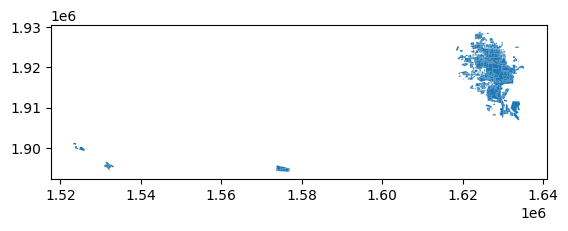

In [58]:
gdf_colonias_hmo.plot()

Observamos que se consideran todas las localidades que pertenecen a hermosillo, pero nos interesan unicamente las urbanas: 

In [59]:
gdf_colonias_hmo['CVE_LOC'].unique()

array([  1, 137, 343])

La clave de la localidad de Hermosillo es 0001: 

In [61]:
gdf_colonias_hmo_urb = gdf_colonias_hmo[gdf_colonias_hmo['CVE_LOC'] == 1]

<Axes: >

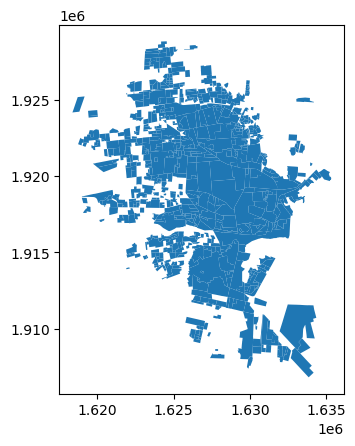

In [62]:
gdf_colonias_hmo_urb.plot()